## Step 0: Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy
from collections import Counter
from mmseg.apis import MMSegInferencer
from mmseg.apis import inference_model, init_model, show_result_pyplot
from PIL import Image
from mmengine import Config
%cd mmsegmentation


/workspaces/ECE661GroupProject_TransferLearning/mmsegmentation


/home/codespace/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## STEP 1: Set Up Helper Functions

In [2]:
# calculate iou between y_true and y_pred
def iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    if np.sum(union) == 0:
        return 0
    else:
        return np.sum(intersection) / np.sum(union)

In [3]:
def dice_score(y_true, y_pred, smooth=1e-5):
    intersection = np.logical_and(y_true, y_pred)
    total_pos_pixels = np.sum(y_true) + np.sum(y_pred)
    dice_coefficient = (2.0 * np.sum(intersection)) / (total_pos_pixels + 1e-7) # Adding epsilon to avoid division by zero
    return dice_coefficient

In [5]:
from sklearn.metrics import f1_score

# make inference
def make_inference(config,checkpoint, img_path, label_path):
    model = init_model(config, checkpoint, device='cuda:0')
    y_true = np.array(Image.open(label_path))
    result = inference_model(model, img_path)
    y_pred = result.pred_sem_seg.data.cpu().numpy().reshape(256,256)

    # print(y_true.shape, y_pred.shape )
    iou_score = iou(y_true, y_pred)
    dice = dice_score(y_true, y_pred)
    fscore = f1_score(y_true, y_pred, average=None)
    return iou_score*100, dice*100, fscore*100

In [6]:
iou_dict = {}
dice_dict = {}
fscore_dict = {}

val_num = [20,105,18,75,98,93,82,36,42,30,5,52,17,67,41,6,107,89,21,14,53,96]

def baseline_score(config_py_path:str, config_pth_path:str)->float:
    
    config_path = f'/workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/{config_py_path}.py'
    checkpoint_path = f'/workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/{config_pth_path}.pth'

    cfg = Config.fromfile(config_path)
    cfg.model.decode_head.num_classes = 2
    cfg.model.auxiliary_head.num_classes = 2
    cfg.randomness = dict(seed=0)

    iou_scores_lst = []
    dice_lst = []
    fscore_lst = []
    for i in val_num:
        img_path = f'/workspaces/ECE661GroupProject_TransferLearning/data/image_png_256_gray/img_{i}.png'
        label_path = f'/workspaces/ECE661GroupProject_TransferLearning/data/fluid_png_256_binary/img_{i}.png'
        iou_score, dice, bfl = make_inference(cfg, checkpoint_path, img_path, label_path)
        iou_scores_lst.append(iou_score)
        dice_lst.append(dice)
        fscore_lst.append(bfl)
    return iou_scores_lst, dice_lst, fscore_lst


## STEP 2: Make Inference Using Different Models

### 1. Unet with PSPNET

In [7]:
!mim download mmsegmentation --config unet-s5-d16_pspnet_4xb4-40k_hrf-256x256 --dest .

processing unet-s5-d16_pspnet_4xb4-40k_hrf-256x256...
pspnet_unet_s5-d16_256x256_40k_hrf_20201227_181818-fdb7e29b.pth exists in /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation
Successfully dumped unet-s5-d16_pspnet_4xb4-40k_hrf-256x256.py to /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation


In [8]:
iou_scores_lst, dice_lst, fscore_lst = baseline_score('unet-s5-d16_pspnet_4xb4-40k_hrf-256x256', 'pspnet_unet_s5-d16_256x256_40k_hrf_20201227_181818-fdb7e29b')
iou_dict["UNET_w_PSPNET"] = np.nanmean(iou_scores_lst)
dice_dict["UNET_w_PSPNET"] = np.nanmean(dice_lst)
fscore_dict["UNET_w_PSPNET"] = np.nanmean(fscore_lst)

/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_unet_s5-d16_256x256_40k_hrf_20201227_181818-fdb7e29b.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_unet_s5-d16_256x256_40k_hrf_20201227_181818-fdb7e29b.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_unet_s5-d16_256x256_40k_hrf_20201227_181818-fdb7e29b.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_unet_s5-d16_256x256_40k_hrf_20201227_181818-fdb7e29b.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_unet_s5-d16_256x256_40k_hrf_20201227_181818-fdb7e29b.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_unet_s5-d16_256x256_40k_hrf_20201227_181818-fdb7e29b.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_unet_s5-d16_256x256_40k_hrf_20201227_181818-fdb7e29b.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_unet_s5-d16_256x256_40k_hrf_20201227_181818-fdb7e29b.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_unet_s5-d16_256x256_40k_hrf_20201227_181818-fdb7e29b.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_unet_s5-d16_256x256_40k_hrf_20201227_181818-fdb7e29b.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_unet_s5-d16_256x256_40k_hrf_20201227_181818-fdb7e29b.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_unet_s5-d16_256x256_40k_hrf_20201227_181818-fdb7e29b.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_unet_s5-d16_256x256_40k_hrf_20201227_181818-fdb7e29b.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_unet_s5-d16_256x256_40k_hrf_20201227_181818-fdb7e29b.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_unet_s5-d16_256x256_40k_hrf_20201227_181818-fdb7e29b.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_unet_s5-d16_256x256_40k_hrf_20201227_181818-fdb7e29b.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_unet_s5-d16_256x256_40k_hrf_20201227_181818-fdb7e29b.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_unet_s5-d16_256x256_40k_hrf_20201227_181818-fdb7e29b.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_unet_s5-d16_256x256_40k_hrf_20201227_181818-fdb7e29b.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_unet_s5-d16_256x256_40k_hrf_20201227_181818-fdb7e29b.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_unet_s5-d16_256x256_40k_hrf_20201227_181818-fdb7e29b.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_unet_s5-d16_256x256_40k_hrf_20201227_181818-fdb7e29b.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


### 2. Unet with FCN

In [9]:
!mim download mmsegmentation --config unet-s5-d16_fcn_4xb4-40k_hrf-256x256 --dest .

processing unet-s5-d16_fcn_4xb4-40k_hrf-256x256...
fcn_unet_s5-d16_256x256_40k_hrf_20201223_173724-d89cf1ed.pth exists in /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation
Successfully dumped unet-s5-d16_fcn_4xb4-40k_hrf-256x256.py to /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation


In [10]:
iou_scores_lst, dice_lst, fscore_lst = baseline_score('unet-s5-d16_fcn_4xb4-40k_hrf-256x256', 'fcn_unet_s5-d16_256x256_40k_hrf_20201223_173724-d89cf1ed')
iou_dict["UNET_w_FCN"] = np.nanmean(iou_scores_lst)
dice_dict["UNET_w_FCN"] = np.nanmean(dice_lst)
fscore_dict["UNET_w_FCN"] = np.nanmean(fscore_lst)

/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_unet_s5-d16_256x256_40k_hrf_20201223_173724-d89cf1ed.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_unet_s5-d16_256x256_40k_hrf_20201223_173724-d89cf1ed.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_unet_s5-d16_256x256_40k_hrf_20201223_173724-d89cf1ed.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_unet_s5-d16_256x256_40k_hrf_20201223_173724-d89cf1ed.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_unet_s5-d16_256x256_40k_hrf_20201223_173724-d89cf1ed.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_unet_s5-d16_256x256_40k_hrf_20201223_173724-d89cf1ed.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_unet_s5-d16_256x256_40k_hrf_20201223_173724-d89cf1ed.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_unet_s5-d16_256x256_40k_hrf_20201223_173724-d89cf1ed.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_unet_s5-d16_256x256_40k_hrf_20201223_173724-d89cf1ed.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_unet_s5-d16_256x256_40k_hrf_20201223_173724-d89cf1ed.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_unet_s5-d16_256x256_40k_hrf_20201223_173724-d89cf1ed.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_unet_s5-d16_256x256_40k_hrf_20201223_173724-d89cf1ed.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_unet_s5-d16_256x256_40k_hrf_20201223_173724-d89cf1ed.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_unet_s5-d16_256x256_40k_hrf_20201223_173724-d89cf1ed.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_unet_s5-d16_256x256_40k_hrf_20201223_173724-d89cf1ed.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_unet_s5-d16_256x256_40k_hrf_20201223_173724-d89cf1ed.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_unet_s5-d16_256x256_40k_hrf_20201223_173724-d89cf1ed.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_unet_s5-d16_256x256_40k_hrf_20201223_173724-d89cf1ed.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_unet_s5-d16_256x256_40k_hrf_20201223_173724-d89cf1ed.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_unet_s5-d16_256x256_40k_hrf_20201223_173724-d89cf1ed.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_unet_s5-d16_256x256_40k_hrf_20201223_173724-d89cf1ed.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_unet_s5-d16_256x256_40k_hrf_20201223_173724-d89cf1ed.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


### 3. Unet with DeepLabV3

In [11]:
!mim download mmsegmentation --config unet-s5-d16_deeplabv3_4xb4-40k_hrf-256x256 --dest .

processing unet-s5-d16_deeplabv3_4xb4-40k_hrf-256x256...
deeplabv3_unet_s5-d16_256x256_40k_hrf_20201226_094047-3a1fdf85.pth exists in /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation
Successfully dumped unet-s5-d16_deeplabv3_4xb4-40k_hrf-256x256.py to /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation


In [12]:
iou_scores_lst, dice_lst, fscore_lst = baseline_score('unet-s5-d16_deeplabv3_4xb4-40k_hrf-256x256', 'deeplabv3_unet_s5-d16_256x256_40k_hrf_20201226_094047-3a1fdf85')
iou_dict["UNET_w_DEEPV3"] = np.nanmean(iou_scores_lst)
dice_dict["UNET_w_DEEPV3"] = np.nanmean(dice_lst)
fscore_dict["UNET_w_DEEPV3"] = np.nanmean(fscore_lst)

/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_unet_s5-d16_256x256_40k_hrf_20201226_094047-3a1fdf85.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_unet_s5-d16_256x256_40k_hrf_20201226_094047-3a1fdf85.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_unet_s5-d16_256x256_40k_hrf_20201226_094047-3a1fdf85.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_unet_s5-d16_256x256_40k_hrf_20201226_094047-3a1fdf85.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_unet_s5-d16_256x256_40k_hrf_20201226_094047-3a1fdf85.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_unet_s5-d16_256x256_40k_hrf_20201226_094047-3a1fdf85.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_unet_s5-d16_256x256_40k_hrf_20201226_094047-3a1fdf85.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_unet_s5-d16_256x256_40k_hrf_20201226_094047-3a1fdf85.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_unet_s5-d16_256x256_40k_hrf_20201226_094047-3a1fdf85.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_unet_s5-d16_256x256_40k_hrf_20201226_094047-3a1fdf85.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_unet_s5-d16_256x256_40k_hrf_20201226_094047-3a1fdf85.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_unet_s5-d16_256x256_40k_hrf_20201226_094047-3a1fdf85.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_unet_s5-d16_256x256_40k_hrf_20201226_094047-3a1fdf85.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_unet_s5-d16_256x256_40k_hrf_20201226_094047-3a1fdf85.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_unet_s5-d16_256x256_40k_hrf_20201226_094047-3a1fdf85.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_unet_s5-d16_256x256_40k_hrf_20201226_094047-3a1fdf85.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_unet_s5-d16_256x256_40k_hrf_20201226_094047-3a1fdf85.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_unet_s5-d16_256x256_40k_hrf_20201226_094047-3a1fdf85.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_unet_s5-d16_256x256_40k_hrf_20201226_094047-3a1fdf85.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_unet_s5-d16_256x256_40k_hrf_20201226_094047-3a1fdf85.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_unet_s5-d16_256x256_40k_hrf_20201226_094047-3a1fdf85.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_unet_s5-d16_256x256_40k_hrf_20201226_094047-3a1fdf85.pth


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


### 4. PSPNet

In [13]:
!mim download mmsegmentation --config pspnet_r50-d8_4xb4-80k_potsdam-512x512 --dest .

processing pspnet_r50-d8_4xb4-80k_potsdam-512x512...
pspnet_r50-d8_4x4_512x512_80k_potsdam_20211219_043541-2dd5fe67.pth exists in /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation
Successfully dumped pspnet_r50-d8_4xb4-80k_potsdam-512x512.py to /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation


In [14]:
iou_scores_lst, dice_lst, fscore_lst = baseline_score('pspnet_r50-d8_4xb4-80k_potsdam-512x512', 'pspnet_r50-d8_4x4_512x512_80k_potsdam_20211219_043541-2dd5fe67')
iou_dict["PSPNET_potsdam"] = np.nanmean(iou_scores_lst)
dice_dict["PSPNET_potsdam"] = np.nanmean(dice_lst)
fscore_dict["PSPNET_potsdam"] = np.nanmean(fscore_lst)

/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_r50-d8_4x4_512x512_80k_potsdam_20211219_043541-2dd5fe67.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_r50-d8_4x4_512x512_80k_potsdam_20211219_043541-2dd5fe67.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_r50-d8_4x4_512x512_80k_potsdam_20211219_043541-2dd5fe67.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_r50-d8_4x4_512x512_80k_potsdam_20211219_043541-2dd5fe67.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_r50-d8_4x4_512x512_80k_potsdam_20211219_043541-2dd5fe67.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_r50-d8_4x4_512x512_80k_potsdam_20211219_043541-2dd5fe67.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_r50-d8_4x4_512x512_80k_potsdam_20211219_043541-2dd5fe67.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_r50-d8_4x4_512x512_80k_potsdam_20211219_043541-2dd5fe67.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_r50-d8_4x4_512x512_80k_potsdam_20211219_043541-2dd5fe67.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_r50-d8_4x4_512x512_80k_potsdam_20211219_043541-2dd5fe67.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_r50-d8_4x4_512x512_80k_potsdam_20211219_043541-2dd5fe67.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_r50-d8_4x4_512x512_80k_potsdam_20211219_043541-2dd5fe67.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_r50-d8_4x4_512x512_80k_potsdam_20211219_043541-2dd5fe67.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_r50-d8_4x4_512x512_80k_potsdam_20211219_043541-2dd5fe67.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_r50-d8_4x4_512x512_80k_potsdam_20211219_043541-2dd5fe67.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_r50-d8_4x4_512x512_80k_potsdam_20211219_043541-2dd5fe67.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_r50-d8_4x4_512x512_80k_potsdam_20211219_043541-2dd5fe67.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_r50-d8_4x4_512x512_80k_potsdam_20211219_043541-2dd5fe67.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_r50-d8_4x4_512x512_80k_potsdam_20211219_043541-2dd5fe67.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_r50-d8_4x4_512x512_80k_potsdam_20211219_043541-2dd5fe67.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_r50-d8_4x4_512x512_80k_potsdam_20211219_043541-2dd5fe67.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/pspnet_r50-d8_4x4_512x512_80k_potsdam_20211219_043541-2dd5fe67.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


### 5. DeepLabV3





In [15]:
!mim download mmsegmentation --config deeplabv3_r50-d8_4xb4-20k_voc12aug-512x512 --dest .

processing deeplabv3_r50-d8_4xb4-20k_voc12aug-512x512...
deeplabv3_r50-d8_512x512_20k_voc12aug_20200617_010906-596905ef.pth exists in /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation
Successfully dumped deeplabv3_r50-d8_4xb4-20k_voc12aug-512x512.py to /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation


In [16]:
iou_scores_lst, dice_lst, fscore_lst = baseline_score('deeplabv3_r50-d8_4xb4-20k_voc12aug-512x512', 'deeplabv3_r50-d8_512x512_20k_voc12aug_20200617_010906-596905ef')
iou_dict["deevpv3_voc"] = np.nanmean(iou_scores_lst)
dice_dict["deevpv3_voc"] = np.nanmean(dice_lst)
fscore_dict["deevpv3_voc"] = np.nanmean(fscore_lst)

/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_r50-d8_512x512_20k_voc12aug_20200617_010906-596905ef.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_r50-d8_512x512_20k_voc12aug_20200617_010906-596905ef.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_r50-d8_512x512_20k_voc12aug_20200617_010906-596905ef.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_r50-d8_512x512_20k_voc12aug_20200617_010906-596905ef.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_r50-d8_512x512_20k_voc12aug_20200617_010906-596905ef.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_r50-d8_512x512_20k_voc12aug_20200617_010906-596905ef.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_r50-d8_512x512_20k_voc12aug_20200617_010906-596905ef.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_r50-d8_512x512_20k_voc12aug_20200617_010906-596905ef.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_r50-d8_512x512_20k_voc12aug_20200617_010906-596905ef.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_r50-d8_512x512_20k_voc12aug_20200617_010906-596905ef.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_r50-d8_512x512_20k_voc12aug_20200617_010906-596905ef.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_r50-d8_512x512_20k_voc12aug_20200617_010906-596905ef.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_r50-d8_512x512_20k_voc12aug_20200617_010906-596905ef.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_r50-d8_512x512_20k_voc12aug_20200617_010906-596905ef.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_r50-d8_512x512_20k_voc12aug_20200617_010906-596905ef.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_r50-d8_512x512_20k_voc12aug_20200617_010906-596905ef.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_r50-d8_512x512_20k_voc12aug_20200617_010906-596905ef.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_r50-d8_512x512_20k_voc12aug_20200617_010906-596905ef.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_r50-d8_512x512_20k_voc12aug_20200617_010906-596905ef.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_r50-d8_512x512_20k_voc12aug_20200617_010906-596905ef.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_r50-d8_512x512_20k_voc12aug_20200617_010906-596905ef.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3_r50-d8_512x512_20k_voc12aug_20200617_010906-596905ef.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


### 6. DeepLabV3Plus (VOC)

In [17]:
!mim download mmsegmentation --config deeplabv3plus_r50-d8_4xb4-20k_voc12aug-512x512 --dest .

processing deeplabv3plus_r50-d8_4xb4-20k_voc12aug-512x512...
deeplabv3plus_r50-d8_512x512_20k_voc12aug_20200617_102323-aad58ef1.pth exists in /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation
Successfully dumped deeplabv3plus_r50-d8_4xb4-20k_voc12aug-512x512.py to /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation


In [18]:
iou_scores_lst, dice_lst, fscore_lst = baseline_score('deeplabv3plus_r50-d8_4xb4-20k_voc12aug-512x512', 'deeplabv3plus_r50-d8_512x512_20k_voc12aug_20200617_102323-aad58ef1')
iou_dict["deevpv3plus_voc"] = np.nanmean(iou_scores_lst)
dice_dict["deevpv3plus_voc"] = np.nanmean(dice_lst)
fscore_dict["deevpv3plus_voc"] = np.nanmean(fscore_lst)

/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r50-d8_512x512_20k_voc12aug_20200617_102323-aad58ef1.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r50-d8_512x512_20k_voc12aug_20200617_102323-aad58ef1.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r50-d8_512x512_20k_voc12aug_20200617_102323-aad58ef1.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r50-d8_512x512_20k_voc12aug_20200617_102323-aad58ef1.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r50-d8_512x512_20k_voc12aug_20200617_102323-aad58ef1.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r50-d8_512x512_20k_voc12aug_20200617_102323-aad58ef1.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r50-d8_512x512_20k_voc12aug_20200617_102323-aad58ef1.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r50-d8_512x512_20k_voc12aug_20200617_102323-aad58ef1.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r50-d8_512x512_20k_voc12aug_20200617_102323-aad58ef1.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r50-d8_512x512_20k_voc12aug_20200617_102323-aad58ef1.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r50-d8_512x512_20k_voc12aug_20200617_102323-aad58ef1.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r50-d8_512x512_20k_voc12aug_20200617_102323-aad58ef1.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r50-d8_512x512_20k_voc12aug_20200617_102323-aad58ef1.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r50-d8_512x512_20k_voc12aug_20200617_102323-aad58ef1.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r50-d8_512x512_20k_voc12aug_20200617_102323-aad58ef1.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r50-d8_512x512_20k_voc12aug_20200617_102323-aad58ef1.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r50-d8_512x512_20k_voc12aug_20200617_102323-aad58ef1.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r50-d8_512x512_20k_voc12aug_20200617_102323-aad58ef1.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r50-d8_512x512_20k_voc12aug_20200617_102323-aad58ef1.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r50-d8_512x512_20k_voc12aug_20200617_102323-aad58ef1.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r50-d8_512x512_20k_voc12aug_20200617_102323-aad58ef1.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r50-d8_512x512_20k_voc12aug_20200617_102323-aad58ef1.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


### 7. DeepLabV3Plus (Potsdam)

In [19]:
!mim download mmsegmentation --config deeplabv3plus_r18-d8_4xb4-80k_potsdam-512x512 --dest .

processing deeplabv3plus_r18-d8_4xb4-80k_potsdam-512x512...
deeplabv3plus_r18-d8_512x512_80k_potsdam_20211219_020601-75fd5bc3.pth exists in /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation
Successfully dumped deeplabv3plus_r18-d8_4xb4-80k_potsdam-512x512.py to /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation


In [20]:
iou_scores_lst, dice_lst, fscore_lst = baseline_score('deeplabv3plus_r18-d8_4xb4-80k_potsdam-512x512', 'deeplabv3plus_r18-d8_512x512_80k_potsdam_20211219_020601-75fd5bc3')
iou_dict["deevpv3plus_potsdam"] = np.nanmean(iou_scores_lst)
dice_dict["deevpv3plus_potsdam"] = np.nanmean(dice_lst)
fscore_dict["deevpv3plus_potsdam"] = np.nanmean(fscore_lst)

/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r18-d8_512x512_80k_potsdam_20211219_020601-75fd5bc3.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 128, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 64, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r18-d8_512x512_80k_potsdam_20211219_020601-75fd5bc3.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 128, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 64, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r18-d8_512x512_80k_potsdam_20211219_020601-75fd5bc3.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 128, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 64, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r18-d8_512x512_80k_potsdam_20211219_020601-75fd5bc3.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 128, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 64, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r18-d8_512x512_80k_potsdam_20211219_020601-75fd5bc3.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 128, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 64, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r18-d8_512x512_80k_potsdam_20211219_020601-75fd5bc3.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 128, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 64, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packa

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r18-d8_512x512_80k_potsdam_20211219_020601-75fd5bc3.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 128, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 64, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r18-d8_512x512_80k_potsdam_20211219_020601-75fd5bc3.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 128, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 64, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r18-d8_512x512_80k_potsdam_20211219_020601-75fd5bc3.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 128, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 64, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packa

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r18-d8_512x512_80k_potsdam_20211219_020601-75fd5bc3.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 128, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 64, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r18-d8_512x512_80k_potsdam_20211219_020601-75fd5bc3.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 128, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 64, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r18-d8_512x512_80k_potsdam_20211219_020601-75fd5bc3.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 128, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 64, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packa

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r18-d8_512x512_80k_potsdam_20211219_020601-75fd5bc3.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 128, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 64, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r18-d8_512x512_80k_potsdam_20211219_020601-75fd5bc3.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 128, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 64, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packa

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r18-d8_512x512_80k_potsdam_20211219_020601-75fd5bc3.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 128, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 64, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r18-d8_512x512_80k_potsdam_20211219_020601-75fd5bc3.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 128, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 64, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r18-d8_512x512_80k_potsdam_20211219_020601-75fd5bc3.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 128, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 64, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packa

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r18-d8_512x512_80k_potsdam_20211219_020601-75fd5bc3.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 128, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 64, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r18-d8_512x512_80k_potsdam_20211219_020601-75fd5bc3.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 128, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 64, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r18-d8_512x512_80k_potsdam_20211219_020601-75fd5bc3.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 128, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 64, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packa

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/deeplabv3plus_r18-d8_512x512_80k_potsdam_20211219_020601-75fd5bc3.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 128, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([6, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 64, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([2]).
Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/

/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


### 8. FCN

In [21]:
!mim download mmsegmentation --config fcn_r50-d8_4xb4-20k_voc12aug-512x512 --dest .

processing fcn_r50-d8_4xb4-20k_voc12aug-512x512...
fcn_r50-d8_512x512_20k_voc12aug_20200617_010715-52dc5306.pth exists in /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation
Successfully dumped fcn_r50-d8_4xb4-20k_voc12aug-512x512.py to /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation


In [22]:
iou_scores_lst, dice_lst, fscore_lst = baseline_score( 'fcn_r50-d8_4xb4-20k_voc12aug-512x512', 'fcn_r50-d8_512x512_20k_voc12aug_20200617_010715-52dc5306')
iou_dict["fcn_voc"] = np.nanmean(iou_scores_lst)
dice_dict["fcn_voc"] = np.nanmean(dice_lst)
fscore_dict["fcn_voc"] = np.nanmean(fscore_lst)

/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_r50-d8_512x512_20k_voc12aug_20200617_010715-52dc5306.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_r50-d8_512x512_20k_voc12aug_20200617_010715-52dc5306.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_r50-d8_512x512_20k_voc12aug_20200617_010715-52dc5306.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_r50-d8_512x512_20k_voc12aug_20200617_010715-52dc5306.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_r50-d8_512x512_20k_voc12aug_20200617_010715-52dc5306.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_r50-d8_512x512_20k_voc12aug_20200617_010715-52dc5306.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_r50-d8_512x512_20k_voc12aug_20200617_010715-52dc5306.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_r50-d8_512x512_20k_voc12aug_20200617_010715-52dc5306.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_r50-d8_512x512_20k_voc12aug_20200617_010715-52dc5306.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_r50-d8_512x512_20k_voc12aug_20200617_010715-52dc5306.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_r50-d8_512x512_20k_voc12aug_20200617_010715-52dc5306.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_r50-d8_512x512_20k_voc12aug_20200617_010715-52dc5306.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_r50-d8_512x512_20k_voc12aug_20200617_010715-52dc5306.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_r50-d8_512x512_20k_voc12aug_20200617_010715-52dc5306.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_r50-d8_512x512_20k_voc12aug_20200617_010715-52dc5306.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_r50-d8_512x512_20k_voc12aug_20200617_010715-52dc5306.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_r50-d8_512x512_20k_voc12aug_20200617_010715-52dc5306.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_r50-d8_512x512_20k_voc12aug_20200617_010715-52dc5306.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_r50-d8_512x512_20k_voc12aug_20200617_010715-52dc5306.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-package

Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_r50-d8_512x512_20k_voc12aug_20200617_010715-52dc5306.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_r50-d8_512x512_20k_voc12aug_20200617_010715-52dc5306.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/opt/conda/envs/openmmlab/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /workspaces/ECE661GroupProject_TransferLearning/mmsegmentation/fcn_r50-d8_512x512_20k_voc12aug_20200617_010715-52dc5306.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([21, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([21, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([2]).


## Step 3: Plot Baseline Results

In [23]:
iou_dict, dice_dict, fscore_dict

({'UNET_w_PSPNET': 0.4544451850748962,
  'UNET_w_FCN': 0.22801305180539388,
  'UNET_w_DEEPV3': 0.22488713458260065,
  'PSPNET_potsdam': 0.5309563110924539,
  'deevpv3_voc': 0.5993961924137464,
  'deevpv3plus_voc': 0.39992879308871615,
  'deevpv3plus_potsdam': 0.7755173146521056,
  'fcn_voc': 0.721550252555173},
 {'UNET_w_PSPNET': 0.8845136395208357,
  'UNET_w_FCN': 0.44714174502639475,
  'UNET_w_DEEPV3': 0.4384862476635514,
  'PSPNET_potsdam': 1.0324521179239154,
  'deevpv3_voc': 1.1612647157512272,
  'deevpv3plus_voc': 0.7666629963675873,
  'deevpv3plus_potsdam': 1.4981816027942898,
  'fcn_voc': 1.3921871817554765},
 {'UNET_w_PSPNET': 0.09310372297919291,
  'UNET_w_FCN': 0.05177531030738269,
  'UNET_w_DEEPV3': 0.040799064841247505,
  'PSPNET_potsdam': 0.9909188066580646,
  'deevpv3_voc': 0.7094080663367628,
  'deevpv3plus_voc': 0.7090776122706225,
  'deevpv3plus_potsdam': 1.30223188944413,
  'fcn_voc': 0.9293228401347043})

In [24]:
import matplotlib.pyplot as plt

def plot_dict(dict_, metric, highlight_top=True):
    data = dict_

    # Sort the dictionary by values in ascending order
    sorted_data = dict(sorted(data.items(), key=lambda item: item[1]))

    # Get the indices of the top or bottom three values based on the highlight_top parameter
    if highlight_top:
        indices_to_highlight = list(sorted_data.keys())[-3:]
    else:
        indices_to_highlight = list(sorted_data.keys())[:3]

    # Plotting
    plt.figure(figsize=(10, 6))

    # Plot all values in grey
    plt.plot(sorted_data.keys(), sorted_data.values(), color='grey', linewidth=2, markersize=8, marker='o')

    # Highlight the top or bottom three values in red
    plt.scatter(indices_to_highlight, [sorted_data[idx] for idx in indices_to_highlight], color='red', s=50, zorder=5)

    plt.title(f'{metric}', weight='bold')
    plt.xlabel('Models')
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    plt.show()


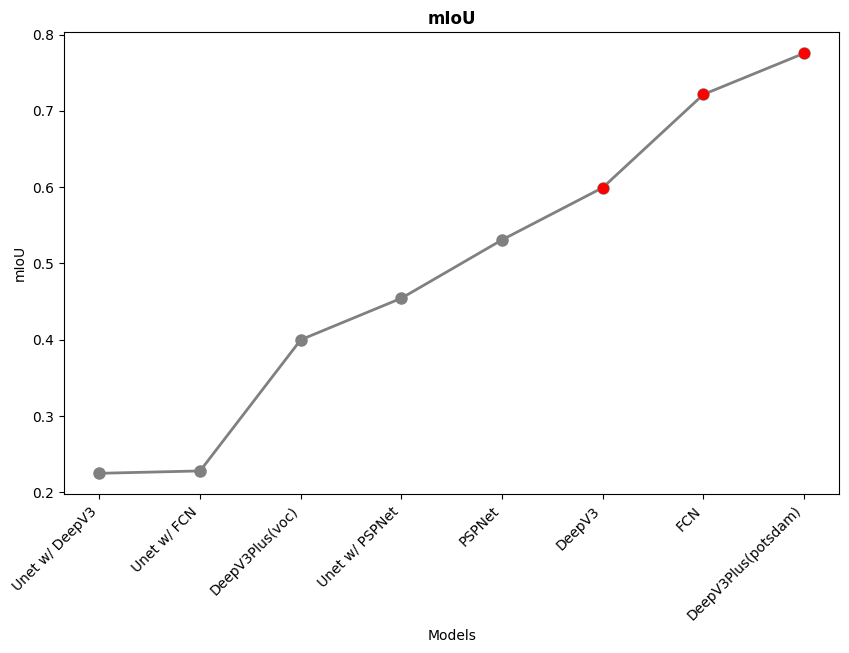

In [28]:
iou_dict_ = {
        'Unet w/ PSPNet':         0.4544451850748962,
        'Unet w/ FCN':            0.22801305180539388,
        'Unet w/ DeepV3':         0.22488713458260065,
        'PSPNet':                 0.5309563110924539,
        'DeepV3':                 0.5993961924137464,
        'DeepV3Plus(voc)':        0.39992879308871615,
        'DeepV3Plus(potsdam)':    0.7755173146521056,
        'FCN':                    0.721550252555173}
plot_dict(iou_dict_, 'mIoU', highlight_top=True)

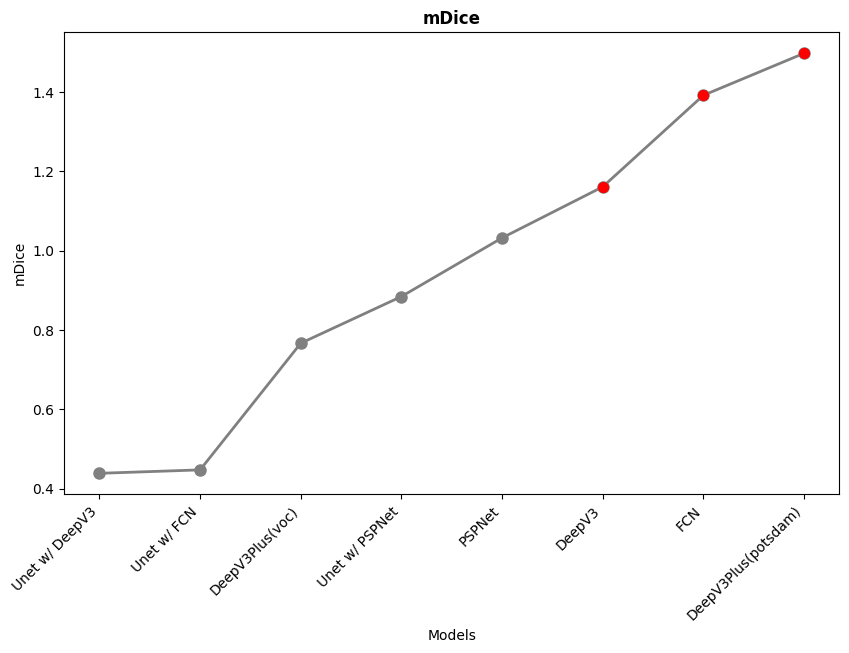

In [29]:
dice_score_dict_ = {'Unet w/ PSPNet':   0.8845136395208357,
  'Unet w/ FCN':                        0.44714174502639475,
  'Unet w/ DeepV3':                     0.4384862476635514,
  'PSPNet':                             1.0324521179239154,
  'DeepV3':                             1.1612647157512272,
  'DeepV3Plus(voc)':                    0.7666629963675873,
  'DeepV3Plus(potsdam)':                1.4981816027942898,
  'FCN':                                1.3921871817554765}
plot_dict(dice_score_dict_, 'mDice', highlight_top=True)

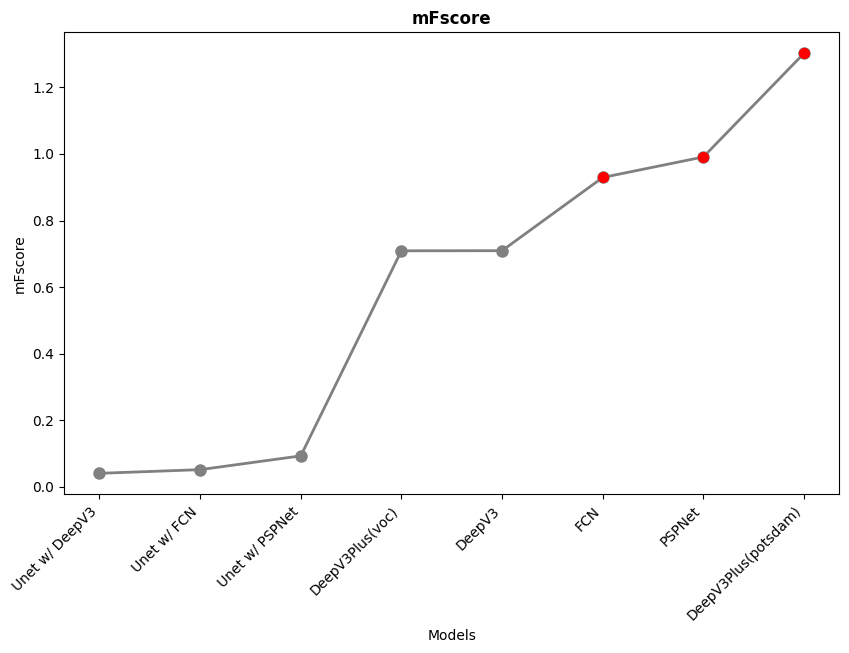

In [30]:
fscore_dict_ = {'Unet w/ PSPNet':   0.09310372297919291,
    'Unet w/ FCN':                  0.05177531030738269,
    'Unet w/ DeepV3':               0.040799064841247505,
    'PSPNet':                       0.9909188066580646,
    'DeepV3':                       0.7094080663367628,
    'DeepV3Plus(voc)':              0.7090776122706225,
    'DeepV3Plus(potsdam)':          1.30223188944413,
    'FCN':                          0.9293228401347043}
plot_dict(fscore_dict_, 'mFscore', highlight_top=True)